# Detail timings for variations of hyperparameters

In [14]:
import os
import sys
import copy
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import astropy.io.fits as pf
import pysap
import tqdm
import corner
import pickle as pkl

from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import class_creator
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from lenstronomy.Plots import chain_plot
from lenstronomy.Util import kernel_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.util as lenstro_util

from slitronomy.Util.plot_util import nice_colorbar, log_cmap

np.random.seed(118)

%matplotlib inline

## Prepare test case

In [15]:
def generate_simple_mock_lens(num_pix=99, delta_pix=0.08):
    # noise sigma
    background_rms = 0.05

    psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
    psf_num_pix = 15

    # data specification (coordinates, etc.)
    _, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
        = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                     inverse=False, left_lower=False)

    kwargs_data = {
        'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
        'transform_pix2angle': Mpix2coord,
        'image_data': np.zeros((num_pix, num_pix)),
        'background_rms': background_rms,
        'noise_map': background_rms * np.ones((num_pix, num_pix)),
    }
    data_class = ImageData(**kwargs_data)

    # PSF specification
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    #print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    psf_class = PSF(**kwargs_psf)

    lens_model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']
    kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0.1, 'e2': -0.2}
    kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0.5, 'ra_0': kwargs_spemd['center_x'], 'dec_0': kwargs_spemd['center_y']}
    kwargs_lens = [kwargs_spemd, kwargs_shear]
    lens_model_class = LensModel(lens_model_list=lens_model_list)

    # list of source light profiles from Galsim (COSMOS galaxy)
    galsim_index = 1
    snr_data = 500
    galsim_data_path = ('../notebooks/data/ring_sims/sims_SNR{}/simring_galsim{}_all.pkl'.format(snr_data, galsim_index))
    [data, truth, lens_model] = pkl.load(open(galsim_data_path, 'rb'))
    galsim_source_highres = truth['source_galsim_3']
    galsim_num_pix = data['num_pix']
    galsim_delta_pix = data['delta_pix']
    source_model_list = ['INTERPOL']
    kwargs_interpol_source = {'image': galsim_source_highres, 
                              'amp': 1000, 'center_x': +0.3, 'center_y': -0.1, 'phi_G': 0, 
                              'scale': galsim_delta_pix/3}
    kwargs_source = [kwargs_interpol_source]
    source_model_class = LightModel(light_model_list=source_model_list)

    kwargs_truth = {
        'kwargs_lens': kwargs_lens, 
        'kwargs_source': kwargs_source, 
        'kwargs_special': {'delta_x_source_grid': 0, 'delta_y_source_grid': 0},
    }

    kwargs_numerics_sim = {'supersampling_factor': 3, 'supersampling_convolution': False}

    # get the simalated lens image (i.e. image plane)
    imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                            kwargs_numerics=kwargs_numerics_sim)

    image_sim_no_noise = imageModel.image(kwargs_lens, kwargs_source)
    bkg = image_util.add_background(image_sim_no_noise, sigma_bkd=background_rms)
    image_sim = image_sim_no_noise + bkg
    data_class.update_data(image_sim)

    return data_class, psf_class, lens_model_class, kwargs_truth

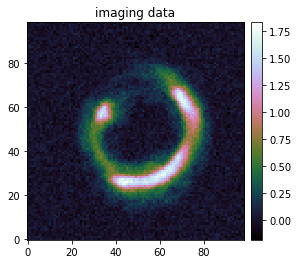

In [16]:
data_class, psf_class, lens_model_class, kwargs_truth = generate_simple_mock_lens(99, 0.08)

plt.title("imaging data")
im = plt.imshow(data_class.data, origin='lower', cmap='cubehelix')
nice_colorbar(im)
plt.show()

## Fixed settings for sparse solver

In [17]:
source_model_class_sparsefit = LightModel(['STARLETS'])
kwargs_source_sparsefit  = [{'n_scales': 6}]  # starlet coeffs that are optimized for

kwargs_sparse_solver_fixed = {
    'source_interpolation': 'bilinear',
    'sparsity_prior_norm': 1,
    'min_threshold': 3,
    'num_iter_source': 20,
    'num_iter_weights': 3,
    'verbose': False,
    'show_steps': False,
    'thread_count': 8,
}

## Time lensing operator construction varying source plane resolution

In [7]:
def timing_lensing_op_subgrid_res(subgrid_res_range, n_repeat=50):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_lensing_op_min_source_size(min_source_grid_range, subgrid_res_fix=2, n_repeat=50):
    """vary minimal source plane grid size"""
    timing_list, timing_sigma_list = [], []
    for min_source_iter in min_source_grid_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(subgrid_res_fix)
        kwargs_sparse_solver_iter['minimal_source_plane'] = True
        kwargs_sparse_solver_iter['fix_minimal_source_plane'] = False
        kwargs_sparse_solver_iter['min_num_pix_source'] = min_source_iter
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return min_source_grid_range, np.array(timing_list), np.array(timing_sigma_list)

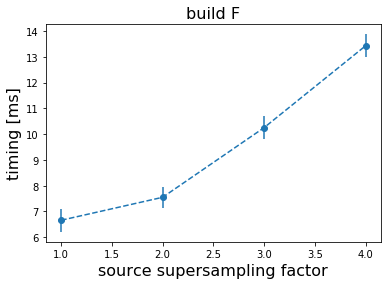

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y_err = timing_lensing_op_subgrid_res(np.arange(1, 5, dtype=int))
ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o')
ax.set_title("build F", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
plt.show()
#fig.savefig("timing_F_subgrid.png")

INFO : source grid has been reduced from 198 to 190 side pixels
INFO : source grid has been reduced from 198 to 182 side pixels
INFO : source grid has been reduced from 198 to 174 side pixels
INFO : source grid has been reduced from 198 to 168 side pixels
INFO : source grid has been reduced from 198 to 160 side pixels
INFO : source grid has been reduced from 198 to 152 side pixels
INFO : source grid has been reduced from 198 to 146 side pixels


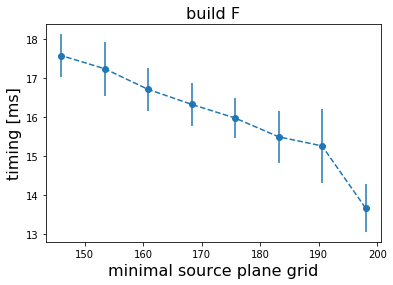

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y_err = timing_lensing_op_min_source_size(np.linspace(198, 146, 8), subgrid_res_fix=2)
ax.set_title("build F", fontsize=16)
ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o')
ax.set_xlabel("minimal source plane grid", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
plt.show()
#fig.savefig("timing_F_sourcesize.png")

## Time noise levels computation

In [10]:
def timing_noise_levels_subgrid_res(subgrid_res_range, n_repeat=10):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
        imageSparseFit_iter.sparseSolver.set_source_wavelet_scales(kwargs_source_sparsefit[0]['n_scales'])
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver._update_source_noise_levels()
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

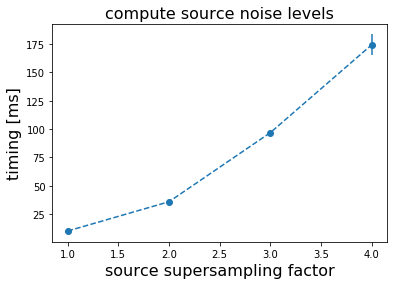

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y_err = timing_noise_levels_subgrid_res(np.arange(1, 5, dtype=int))
ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o')
ax.set_title("compute source noise levels", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
plt.show()
#fig.savefig("timing_noise_S_subgrid.png")

## Time spectral norm computation

In [12]:
def timing_spectral_norm_subgrid_res(subgrid_res_range, n_repeat=10, force_no_fix=False):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        if force_no_fix:
            kwargs_sparse_solver_iter['fixed_spectral_norm_source'] = None
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
        imageSparseFit_iter.sparseSolver.set_source_wavelet_scales(kwargs_source_sparsefit[0]['n_scales'])
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            if imageSparseFit_iter.sparseSolver.spectral_norm_source_is_fixed:
                pass
                #print(imageSparseFit_iter.sparseSolver.spectral_norm_source)
            else:
                imageSparseFit_iter.sparseSolver.update_spectral_norm_source()
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

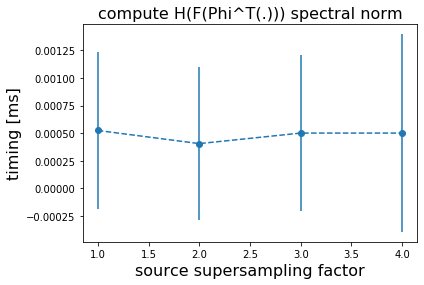

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y_err = timing_spectral_norm_subgrid_res(np.arange(1, 5, dtype=int), force_no_fix=False)
ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o')
ax.set_title("compute H(F(Phi^T(.))) spectral norm", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
plt.show()
#fig.savefig("timing_spectral_S_subgrid.png")

## Time source optimization (lensing op + solver)

In [14]:
def timing_solve_source_subgrid_res(subgrid_res_range, n_repeat=5):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for subgrid_res_iter in subgrid_res_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(subgrid_res_iter)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            _, _, _ = imageSparseFit_iter.image_sparse_solve(kwargs_lens, kwargs_source_sparsefit)
            timing_list_sub.append(time.time() - start)
            #print(imageSparseFit_iter.sparseSolver.best_fit_reduced_chi2)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return subgrid_res_range, np.array(timing_list), np.array(timing_sigma_list)

def timing_solve_source_min_source_size(min_source_grid_range, subgrid_res_fix=2, n_repeat=5):
    """vary source grid resolution"""
    timing_list, timing_sigma_list = [], []
    for min_source_iter in min_source_grid_range:
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(subgrid_res_fix)
        kwargs_sparse_solver_iter['minimal_source_plane'] = True
        kwargs_sparse_solver_iter['fix_minimal_source_plane'] = False
        kwargs_sparse_solver_iter['min_num_pix_source'] = min_source_iter
        imageSparseFit_iter = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            _, _, _ = imageSparseFit_iter.image_sparse_solve(kwargs_truth['kwargs_lens'], kwargs_source_sparsefit)
            timing_list_sub.append(time.time() - start)
            #print(imageSparseFit_iter.sparseSolver.best_fit_reduced_chi2)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return min_source_grid_range, np.array(timing_list), np.array(timing_sigma_list)


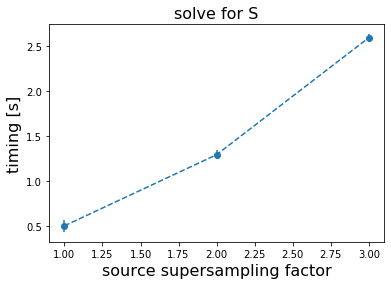

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y_err = timing_solve_source_subgrid_res(np.arange(1, 4, dtype=int))
ax.errorbar(x, y, yerr=y_err, linestyle='--', marker='o')
ax.set_title("solve for S", fontsize=16)
ax.set_xlabel("source supersampling factor", fontsize=16)
ax.set_ylabel("timing [s]", fontsize=16)
plt.show()
#fig.savefig("timing_solve_S_subgrid.png")

INFO : source grid has been reduced from 198 to 180 side pixels
INFO : source grid has been reduced from 198 to 162 side pixels
INFO : source grid has been reduced from 198 to 146 side pixels


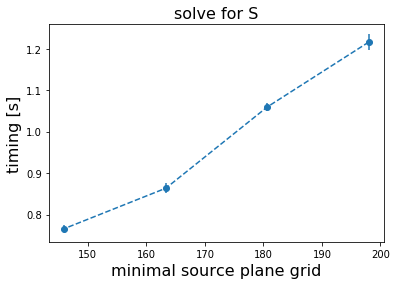

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
x, y, y_err = timing_solve_source_min_source_size(np.linspace(198, 146, 4), subgrid_res_fix=2)
ax.errorbar(x, y, yerr=y_err, linestyle='--', marker='o')
ax.set_title("solve for S", fontsize=16)
ax.set_xlabel("minimal source plane grid", fontsize=16)
ax.set_ylabel("timing [s]", fontsize=16)
plt.show()
#fig.savefig("timing_solve_S_sourcesize.png")

## Time lensing operator computation for different image plane sizes

In [27]:
def timing_lensing_op_num_pix(num_pix_range, base_num_pix=99, base_delta_pix=0.08, fix_subgrid_res=2, n_repeat=50):
    """vary number of image pixels"""
    timing_list, timing_sigma_list = [], []
    for num_pix_var in num_pix_range:
        delta_pix_var = num_pix_var / base_num_pix * base_delta_pix  # to keep the same apparent size of the mock lens
        data_class_var, _, _, _ = generate_simple_mock_lens(num_pix=num_pix_var, delta_pix=delta_pix_var)
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(fix_subgrid_res)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class_var, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            imageSparseFit_iter.sparseSolver.lensingOperator.update_mapping(kwargs_truth['kwargs_lens'])
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return num_pix_range, np.array(timing_list), np.array(timing_sigma_list)

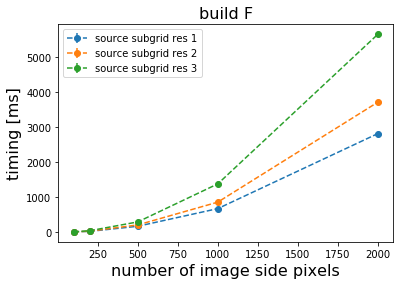

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for sgr in [1, 2, 3]:
    x, y, y_err = timing_lensing_op_num_pix([99, 200, 500, 1000, 2000], fix_subgrid_res=sgr, n_repeat=1)
    ax.errorbar(x, y * 1000, yerr=y_err*1000, linestyle='--', marker='o', label=f"source subgrid res {sgr}")
ax.set_title("build F", fontsize=16)
ax.set_xlabel("number of image side pixels", fontsize=16)
ax.set_ylabel("timing [ms]", fontsize=16)
ax.legend()
plt.show()
#fig.savefig("timing_F_numpix.png")

## Time source optimization for different image plane sizes (lensing op + solver)

In [36]:
def timing_solve_source_num_pix(num_pix_range, base_num_pix=99, base_delta_pix=0.08, fix_subgrid_res=2, n_repeat=50):
    """vary number of image pixels"""
    timing_list, timing_sigma_list = [], []
    for num_pix_var in num_pix_range:
        delta_pix_var = num_pix_var / base_num_pix * base_delta_pix  # to keep the same apparent size of the mock lens
        data_class_var, _, _, _ = generate_simple_mock_lens(num_pix=num_pix_var, delta_pix=delta_pix_var)
        kwargs_sparse_solver_iter = copy.deepcopy(kwargs_sparse_solver_fixed)
        kwargs_sparse_solver_iter['subgrid_res_source'] = int(fix_subgrid_res)
        kwargs_sparse_solver_iter['minimal_source_plane'] = False
        imageSparseFit_iter = ImageSparseFit(data_class_var, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class_sparsefit,
                                likelihood_mask=None,
                                kwargs_sparse_solver=kwargs_sparse_solver_iter)
        timing_list_sub = []
        for _ in range(n_repeat):
            start = time.time()
            _, _, _ = imageSparseFit_iter.image_sparse_solve(kwargs_truth['kwargs_lens'], kwargs_source_sparsefit)
            timing_list_sub.append(time.time() - start)
        timing_list.append(np.mean(timing_list_sub))
        timing_sigma_list.append(np.std(timing_list_sub))
    return num_pix_range, np.array(timing_list), np.array(timing_sigma_list)

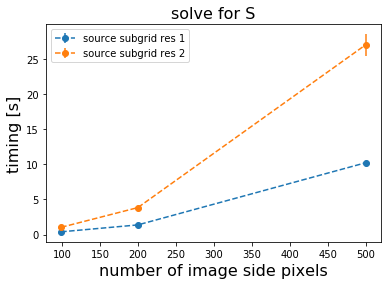

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for sgr in [1, 2]:
    x, y, y_err = timing_solve_source_num_pix([99, 200, 500], fix_subgrid_res=sgr, n_repeat=5)
    ax.errorbar(x, y, yerr=y_err, linestyle='--', marker='o', label=f"source subgrid res {sgr}")
ax.set_title("solve for S", fontsize=16)
ax.set_xlabel("number of image side pixels", fontsize=16)
ax.set_ylabel("timing [s]", fontsize=16)
ax.legend()
plt.show()
#fig.savefig("timing_solve_S_numpix.png")